In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import math
import numba
from numba import cuda
import cv2

# Tạo code cho phép chập

In [2]:
@cuda.jit
def corrolation(Input, fil, Output):
    row, col = cuda.grid(2)
    rn = math.floor(fil.shape[0]/2)
    if (rn < row < Output.shape[0]-rn) and  (rn < col < Output.shape[1]-rn):
        tmp = 0.
        for i in range(-rn,rn+1):
            for j in range(-rn,rn+1):
                if Output.shape[0] > row+i >= 0 and Output.shape[1] > col+j >= 0 :
                    tmp += Input[row+i,col+j]*fil[i,j]
                
                    
        Output[row,col] = tmp
    else:
        Output[row,col] = Input[row,col]
        

In [3]:
A = cv2.imread(r"images/Median.jpg",cv2.IMREAD_GRAYSCALE)
B = np.zeros_like(A)
fil = np.ones((5,5))/25
fil_global_mem = cuda.to_device(fil)
A_global_mem = cuda.to_device(A)
B_global_mem = cuda.device_array(B.shape)
threadsperblock = (32, 32)
blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(A.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)
corrolation[blockspergrid, threadsperblock](A_global_mem,fil_global_mem,B_global_mem)
B = B_global_mem.copy_to_host()


In [4]:
A

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [5]:
B

array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.]])

# Tạo code cho bộ lọc Trung vị

In [6]:
fil_size = 5
fil_size_flat = 25
rn = 2
med = 13
@cuda.jit
def median_filter(Input, Output):
   
    row, col = cuda.grid(2)
    windows = cuda.local.array(fil_size_flat, numba.int32)
    if (0 < row < Output.shape[0]-1) and  (0 < col < Output.shape[1]-1):
        index = 0
        for i in range(row-rn, row+rn+1):
            for j in range(col-rn, col+rn+1):
                if i >= 0 and j >= 0 and i < Output.shape[0] and j < Output.shape[1]:
                    windows[index] = Input[i, j]
                else:
                    windows[index] = 0
                index += 1
        for i in range(fil_size_flat-1):
            min_idx = i
            for j in range(1, fil_size_flat):
                if windows[min_idx] > windows[j]:
                    min_idx = j
                    windows[j], windows[min_idx] = windows[min_idx] , windows[j]           
        Output[row,col] = windows[med]
    

In [7]:
import numpy as np
import cv2
import time
A = cv2.imread(r"C:\Users\Admin\Lena.png",cv2.IMREAD_GRAYSCALE)
A = cv2.resize(A,(5000,5000))
B = np.zeros_like(A)
A_global_mem = cuda.to_device(A)
B_global_mem = cuda.device_array(B.shape)
threadsperblock = (32, 32)
blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(A.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)
arr_gpu = []
arr_cpu = []

arr_gpu = []
arr_cpu = []

for i in range(30):
        start = time.time()
        median_filter[blockspergrid, threadsperblock](A_global_mem, B_global_mem)
        #B = B_global_mem.copy_to_host()
        arr_gpu.append(time.time()-start)
        start = time.time()
        res = cv2.medianBlur(A,5)
        arr_cpu.append(time.time()-start)



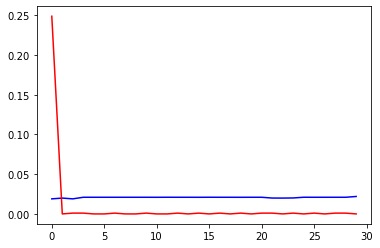

In [8]:
plt.plot(arr_cpu,'b')
plt.plot(arr_gpu,'r')